In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geoopt
import math

import os
from tqdm.auto import tqdm
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable


/home/lfranco/miniconda3/envs/openmmlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from core.active.floating_region import FloatingRegionScore

# Draw Geodesics

In [27]:
P_MLR = torch.tensor([[-0.3258, -0.4310],
        [ 0.2658,  0.5066],
        [ 0.6253, -0.6351],
        [ 0.4510,  0.6694],
        [-0.5733, -0.4884],
        [ 0.1231,  0.3266],
        [ 0.1263,  0.0432],
        [ 0.0943,  0.1899],
        [ 0.7023,  0.1074],
        [ 0.6826,  0.6527],
        [-0.5843,  0.1470],
        [-0.4039, -0.6343],
        [-0.1877, -0.2451],
        [ 0.5358,  0.3728],
        [ 0.3439,  0.5655],
        [ 0.2637,  0.2114],
        [-0.6096,  0.4836],
        [ 0.4321,  0.3415],
        [ 0.6081,  0.2848]])

P_MLR = -P_MLR

A_MLR = torch.tensor([[-0.6896, -0.4054],
        [ 0.2930, -0.3087],
        [ 0.5112, -0.5281],
        [-0.0044, -0.0867],
        [ 0.4051, -0.3565],
        [ 0.6504, -0.0788],
        [-0.6304, -0.4177],
        [-0.6173, -0.5994],
        [-0.2758,  0.0821],
        [-0.5704,  0.4556],
        [ 0.5451,  0.0734],
        [-0.2479, -0.5213],
        [-0.0068,  0.0698],
        [ 0.5669,  0.3713],
        [-0.4413,  0.4827],
        [-0.5874,  0.6429],
        [-0.6557,  0.5337],
        [ 0.0320,  0.1674],
        [-0.3747, -0.2528]])

In [28]:
dx = A_MLR[:,0] - P_MLR[:, 0]
dy = A_MLR[:,1] - P_MLR[:, 1]

In [ ]:
dx.shape, dy.shape

In [ ]:
fig = plt.figure(figsize=(10, 10), clear=True)
ax = fig.add_subplot(111)

scatter1 = ax.scatter(P_MLR[:,0], P_MLR[:,1], alpha=.75, s=7, cmap='tab10')

plt.arrow(P_MLR[0,0], P_MLR[0,1], dx[0], dy[0])
plt.arrow(P_MLR[1,0], P_MLR[1,1], dx[1], dy[1])
plt.arrow(P_MLR[2,0], P_MLR[2,1], dx[2], dy[2])
plt.arrow(P_MLR[3,0], P_MLR[3,1], dx[3], dy[3])
plt.arrow(P_MLR[4,0], P_MLR[4,1], dx[4], dy[4])
plt.arrow(P_MLR[5,0], P_MLR[5,1], dx[5], dy[5])

boundary = plt.Circle((0, 0), 1, fc="none", ec="k")
ax.add_patch(boundary)
ax.axis("off")

In [ ]:
fig = plt.figure(figsize=(10, 10), clear=True)
ax = fig.add_subplot(111)

plt.arrow(P_MLR[0,0], P_MLR[0,1], dx[0], dy[0])
plt.arrow(P_MLR[1,0], P_MLR[1,1], dx[1], dy[1])
plt.arrow(P_MLR[2,0], P_MLR[2,1], dx[2], dy[2])
plt.arrow(P_MLR[8,0], P_MLR[8,1], dx[8], dy[8])
plt.arrow(P_MLR[10,0], P_MLR[10,1], dx[10], dy[10])
plt.arrow(P_MLR[13,0], P_MLR[13,1], dx[13], dy[13])

scatter2 = ax.scatter(P_MLR[0,0], P_MLR[0,1], alpha=1., s=80, c=[extract_color(0)], marker=(5,1))
scatter2 = ax.scatter(P_MLR[1,0], P_MLR[1,1], alpha=1., s=80, c=[extract_color(1)], marker=(5,1))
scatter2 = ax.scatter(P_MLR[2,0], P_MLR[2,1], alpha=1., s=80, c=[extract_color(2)], marker=(5,1))
scatter2 = ax.scatter(P_MLR[8,0], P_MLR[8,1], alpha=1., s=80, c=[extract_color(8)], marker=(5,1))
scatter2 = ax.scatter(P_MLR[10,0], P_MLR[10,1], alpha=1., s=80, c=[extract_color(10)], marker=(5,1))
scatter2 = ax.scatter(P_MLR[13,0], P_MLR[13,1], alpha=1., s=80, c=[extract_color(13)], marker=(5,1))

boundary = plt.Circle((0, 0), 1, fc="none", ec="k")
ax.add_patch(boundary)
ax.axis("off")

# Plot Test Embeddings

In [3]:
def extract_color(c):
    cityspallete = {
            0 :  [128, 64,  128],
            1 :  [244, 35,  232],
            2 :  [70,  70,  70],
            3 :  [102, 102, 156],
            4 :  [190, 153, 153],
            5 :  [153, 153, 153],
            6 :  [250, 170, 30],
            7 :  [220, 220, 0],
            8 :  [107, 142, 35],
            9 :  [152, 251, 152],
            10 : [0,   130, 180],
            11 : [220, 20,  60],
            12 : [255, 0,   0],
            13 : [0,   0,   142],
            14 : [0,   0,   70],
            15 : [0,   60,  100],
            16 : [0,   80,  100],
            17 : [0,   0,   230],
            18 : [119, 11,  32],
            255: [255,   255,   255]}
    return [color/255 for color in cityspallete[c]]

def extract_classname(c):
        trainid2name = {
            0: "road",
            1: "sidewalk",
            2: "building",
            3: "wall",
            4: "fence",
            5: "pole",
            6: "light",
            7: "sign",
            8: "vegetation",
            9: "terrain",
            10: "sky",
            11: "person",
            12: "rider",
            13: "car",
            14: "truck",
            15: "bus",
            16: "train",
            17: "motocycle",
            18: "bicycle",
        }
        return trainid2name[c]

def get_color_pallete(npimg):
    out_img = Image.fromarray(npimg.astype('uint8')).convert('P')
    cityspallete = [
        128, 64, 128,
        244, 35, 232,
        70, 70, 70,
        102, 102, 156,
        190, 153, 153,
        153, 153, 153,
        250, 170, 30,
        220, 220, 0,
        107, 142, 35,
        152, 251, 152,
        0, 130, 180,
        220, 20, 60,
        255, 0, 0,
        0, 0, 142,
        0, 0, 70,
        0, 60, 100,
        0, 80, 100,
        0, 0, 230,
        119, 11, 32,
    ]
    out_img.putpalette(cityspallete)
    return out_img
    
    
def extract_legend(frequent=None):
    most_frequent_class = [0, 1, 2, 8, 10, 13]

    if frequent == 'most':
        patchList = [mpatches.Patch(color=extract_color(k), label=extract_classname(k)) for k in most_frequent_class]
    elif frequent == 'less':
        patchList = [mpatches.Patch(color=extract_color(k), label=extract_classname(k)) for k in range(19) if k not in most_frequent_class]
    else:
        patchList = [mpatches.Patch(color=extract_color(k), label=extract_classname(k)) for k in range(19)]
        
    return patchList

In [4]:
root_path = 'results/source_free/dlv3_hyper_64_WN_5perc_certuncert_02to05/test'

embed_path = root_path + '/embed'
pred_path = root_path + '/pred'
label_path = root_path + '/label'
output_path = root_path + '/output'

In [2]:
embed_tensor = torch.empty(0, 64, 160, 320) 
pred_tensor = torch.empty(0, 160, 320) 
label_tensor = torch.empty(0, 160, 320)    
output_tensor = torch.empty(0, 19, 160, 320) 

# embed_tensor = torch.empty(0, 64, 1024, 2048) 
# pred_tensor = torch.empty(0, 1024, 2048) 
# label_tensor = torch.empty(0, 1024, 2048)    
# output_tensor = torch.empty(0, 19, 1024, 2048)

size = embed_tensor.shape[-2:]

for file_name in tqdm(os.listdir(embed_path)):

    embed = torch.load(os.path.join(embed_path, file_name))
    # embed = F.interpolate(embed.float(), size=size, mode='bilinear', align_corners=True)
    embed_tensor = torch.cat((embed_tensor, embed.cpu()), dim=0)

    pred = torch.load(os.path.join(pred_path, file_name))
    pred = F.interpolate(pred.unsqueeze(0).float(), size=size, mode='nearest')
    pred_tensor = torch.cat((pred_tensor, pred.squeeze(0).cpu()), dim=0)

    label = torch.load(os.path.join(label_path, file_name))
    label = F.interpolate(label.unsqueeze(0).float(), size=size, mode='nearest')
    label_tensor = torch.cat((label_tensor, label.squeeze(0).cpu()), dim=0)

    output = torch.load(os.path.join(output_path, file_name))
    output = F.interpolate(output.float(), size=size, mode='nearest')
    output_tensor = torch.cat((output_tensor, output.cpu()), dim=0)


100%|██████████| 500/500 [09:44<00:00,  1.17s/it]


In [3]:
torch.save(embed_tensor, os.path.join(root_path, 'embed_tensor.pt'))
torch.save(pred_tensor, os.path.join(root_path, 'pred_tensor.pt'))
torch.save(label_tensor, os.path.join(root_path, 'label_tensor.pt'))
torch.save(output_tensor, os.path.join(root_path, 'output_tensor.pt'))

In [5]:
embed_tensor = torch.load(os.path.join(root_path, 'embed_tensor.pt'))
pred_tensor = torch.load(os.path.join(root_path, 'pred_tensor.pt'))
label_tensor = torch.load(os.path.join(root_path, 'label_tensor.pt'))
output_tensor = torch.load(os.path.join(root_path, 'output_tensor.pt'))

In [7]:
# Check Min, Max, Mean Radius
embed_tensor_norm = torch.norm(embed_tensor, dim=1, keepdim=False)
all_norm = embed_tensor_norm.flatten()
all_norm.min().item(), all_norm.max().item(), all_norm.mean().item()

(0.102155613839837, 0.9365012161028671, 0.35545884509828796)

In [6]:
floating_region_score = FloatingRegionScore(in_channels=19, size=3)

In [8]:
idx = 0

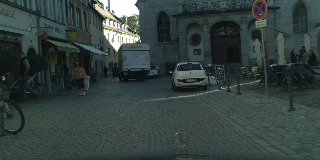

In [13]:
img_list = os.listdir(embed_path)
name = img_list[idx][:-3]

img = Image.open(os.path.join('datasets/cityscapes/leftImg8bit/val/', img_list[idx].split('_')[0], img_list[idx][:-3] + '_leftImg8bit.png'))
img = img.resize((320, 160), Image.NEAREST)
img

# Correlation plots

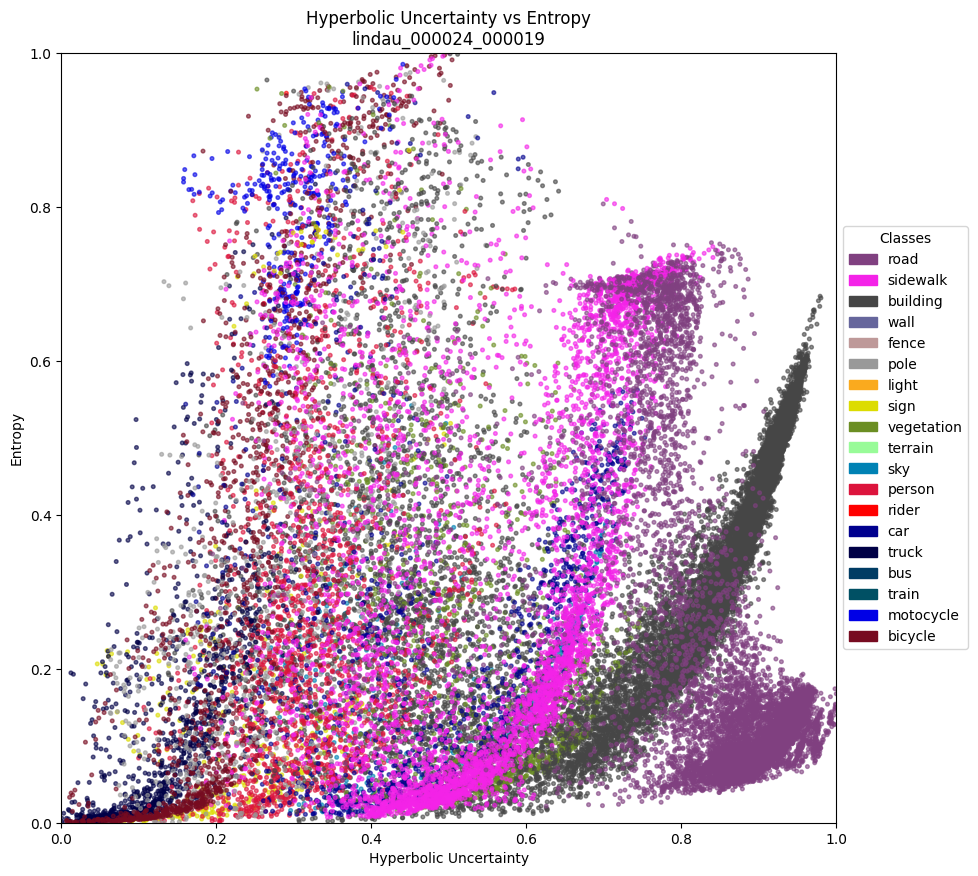

In [14]:

output_sel = output_tensor[idx].unsqueeze(0)
embed_sel = embed_tensor[idx].unsqueeze(0)

_, impurity, entropy = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='entropy', pur_type='ripu')
_, _, hyp_uncert = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='hyperbolic', pur_type='ripu')
hyp_cert = 1 - hyp_uncert
ent_cert = 1 - entropy



color_list = [extract_color(c) for c in pred_tensor[idx].reshape(-1).tolist()]

fig = plt.figure(figsize=(10, 10), clear=True)
ax = fig.add_subplot(111)

scatter1 = ax.scatter(hyp_uncert.reshape(-1), entropy.reshape(-1), c=color_list, alpha=.6, s=7)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Hyperbolic Uncertainty')
ax.set_ylabel('Entropy')
ax.set_title('Hyperbolic Uncertainty vs Entropy\n'+name)

patchList = extract_legend()
plt.legend(handles=patchList, loc='center left', bbox_to_anchor=(1, 0.5), title="Classes")
plt.savefig('./visualizzazioni/'+name+'_ent_vs_hyp.png')

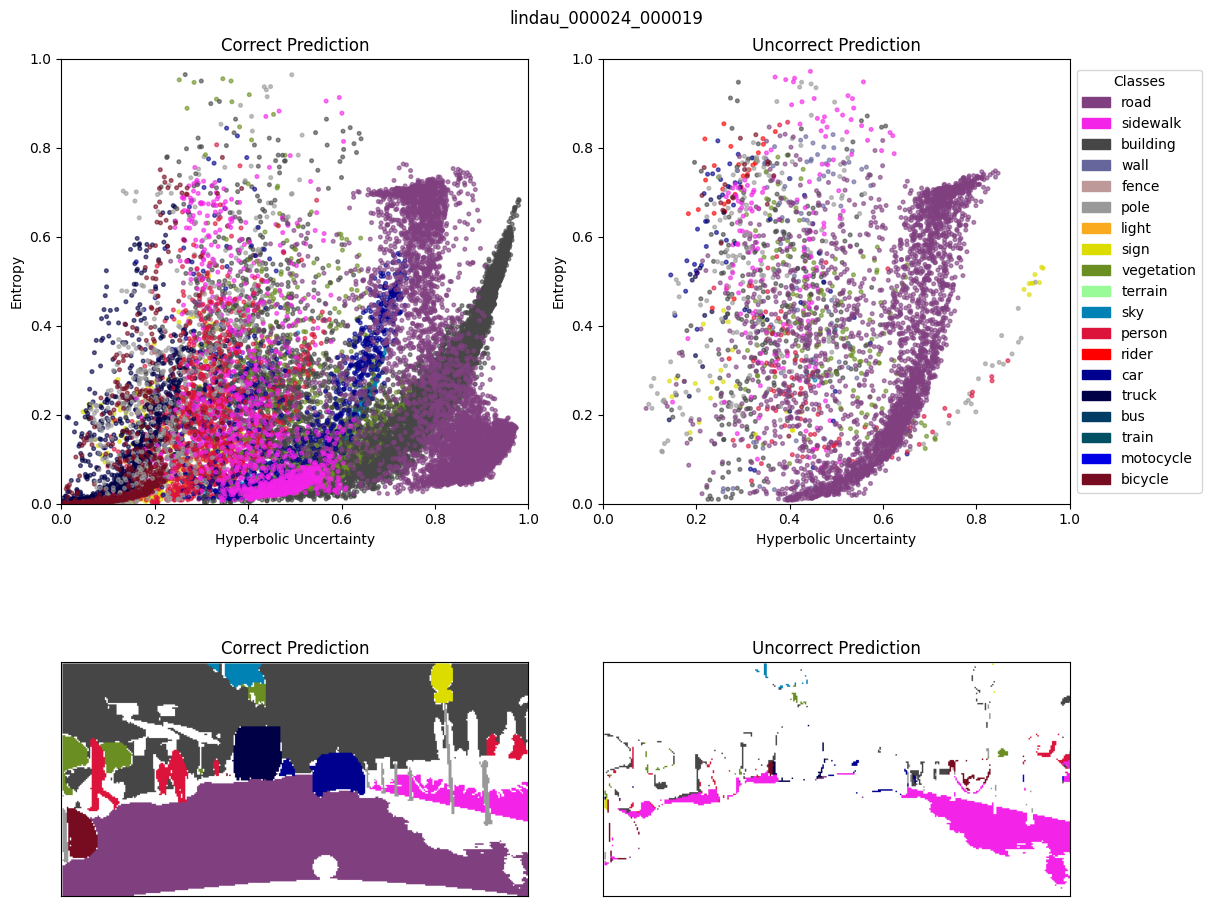

In [165]:
# idx = 0

output_sel = output_tensor[idx].unsqueeze(0)
embed_sel = embed_tensor[idx].unsqueeze(0)

mask_known = label_tensor[idx] != 255
mask_correct = pred_tensor[idx] == label_tensor[idx]
mask_uncorrect = pred_tensor[idx] != label_tensor[idx]
mask_correct = mask_correct & mask_known
mask_uncorrect = mask_uncorrect & mask_known
# mask = torch.ones_like(pred_tensor[idx])

mask_correct = mask_correct.reshape(-1)
mask_uncorrect = mask_uncorrect.reshape(-1)

_, impurity, entropy = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='entropy', pur_type='ripu')
_, _, hyp_uncert = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='hyperbolic', pur_type='ripu')
hyp_cert = 1 - hyp_uncert
ent_cert = 1 - entropy

# pred_flatten = pred_tensor[idx].reshape(-1)
# pred_correct = pred_flatten[mask_correct]
# color_list = [extract_color(c) for c in pred_correct.tolist()]

label_flatten = label_tensor[idx].reshape(-1)
label_correct = label_flatten[mask_correct]
color_list = [extract_color(c) for c in label_correct.tolist()]

fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout = True) # constrained_layout = True

# fig = plt.figure(figsize=(10, 10), clear=True)
# ax1, ax2 = fig.add_subplot(1,2)

hyp_uncert_correct = hyp_uncert.reshape(-1)[mask_correct]
entropy_correct = entropy.reshape(-1)[mask_correct]
scatter1 = axes[0,0].scatter(hyp_uncert_correct, entropy_correct, c=color_list, alpha=.6, s=7)

axes[0,0].set_xlim(0, 1)
axes[0,0].set_ylim(0, 1)
axes[0,0].set_xlabel('Hyperbolic Uncertainty')
axes[0,0].set_ylabel('Entropy')
axes[0,0].set_title('Correct Prediction')



# pred_uncorrect = pred_flatten[mask_uncorrect]
# color_list = [extract_color(c) for c in pred_uncorrect.tolist()]

label_uncorrect = label_flatten[mask_uncorrect]
color_list = [extract_color(c) for c in label_uncorrect.tolist()]

hyp_uncert_uncorrect = hyp_uncert.reshape(-1)[mask_uncorrect]
entropy_uncorrect = entropy.reshape(-1)[mask_uncorrect]
scatter1 = axes[0,1].scatter(hyp_uncert_uncorrect, entropy_uncorrect, c=color_list, alpha=.6, s=7)

axes[0,1].set_xlim(0, 1)
axes[0,1].set_ylim(0, 1)
axes[0,1].set_xlabel('Hyperbolic Uncertainty')
axes[0,1].set_ylabel('Entropy')
axes[0,1].set_title('Uncorrect Prediction')

patchList = extract_legend()
axes[0,1].legend(handles=patchList, loc='center left', bbox_to_anchor=(1, 0.5), title="Classes")




mask_known = label_tensor[idx] != 255
mask_correct = label_tensor[idx] == pred_tensor[idx]
total_mask = mask_known & mask_correct
total_mask = total_mask.cpu().numpy() * 1.

# pred_np_image = np.asarray(get_color_pallete(pred_tensor[idx].cpu().numpy()))

axes[1,0].set_title('Correct Prediction')
# axes[1,0].imshow(label_tensor[idx])
label_correct = pred_tensor[idx].cpu().numpy()*total_mask + 255*(1-total_mask)
im_score = axes[1,0].imshow(get_color_pallete(label_correct), alpha=1.)
axes[1,0].xaxis.set_visible(False)
axes[1,0].yaxis.set_visible(False)

mask_uncorrect = label_tensor[idx] != pred_tensor[idx]
total_mask = mask_known & mask_uncorrect
total_mask = total_mask.cpu().numpy() * 1.

axes[1,1].set_title('Uncorrect Prediction')
# axes[1,1].imshow(label_tensor[idx])
label_uncorrect = pred_tensor[idx].cpu().numpy()*total_mask + 255*(1-total_mask)
im_score = axes[1,1].imshow(get_color_pallete(label_uncorrect), alpha=1.)
axes[1,1].xaxis.set_visible(False)
axes[1,1].yaxis.set_visible(False)


fig.suptitle(name)
plt.savefig('./visualizzazioni/'+name+'_ent_vs_hyp_corr_uncorr.png')

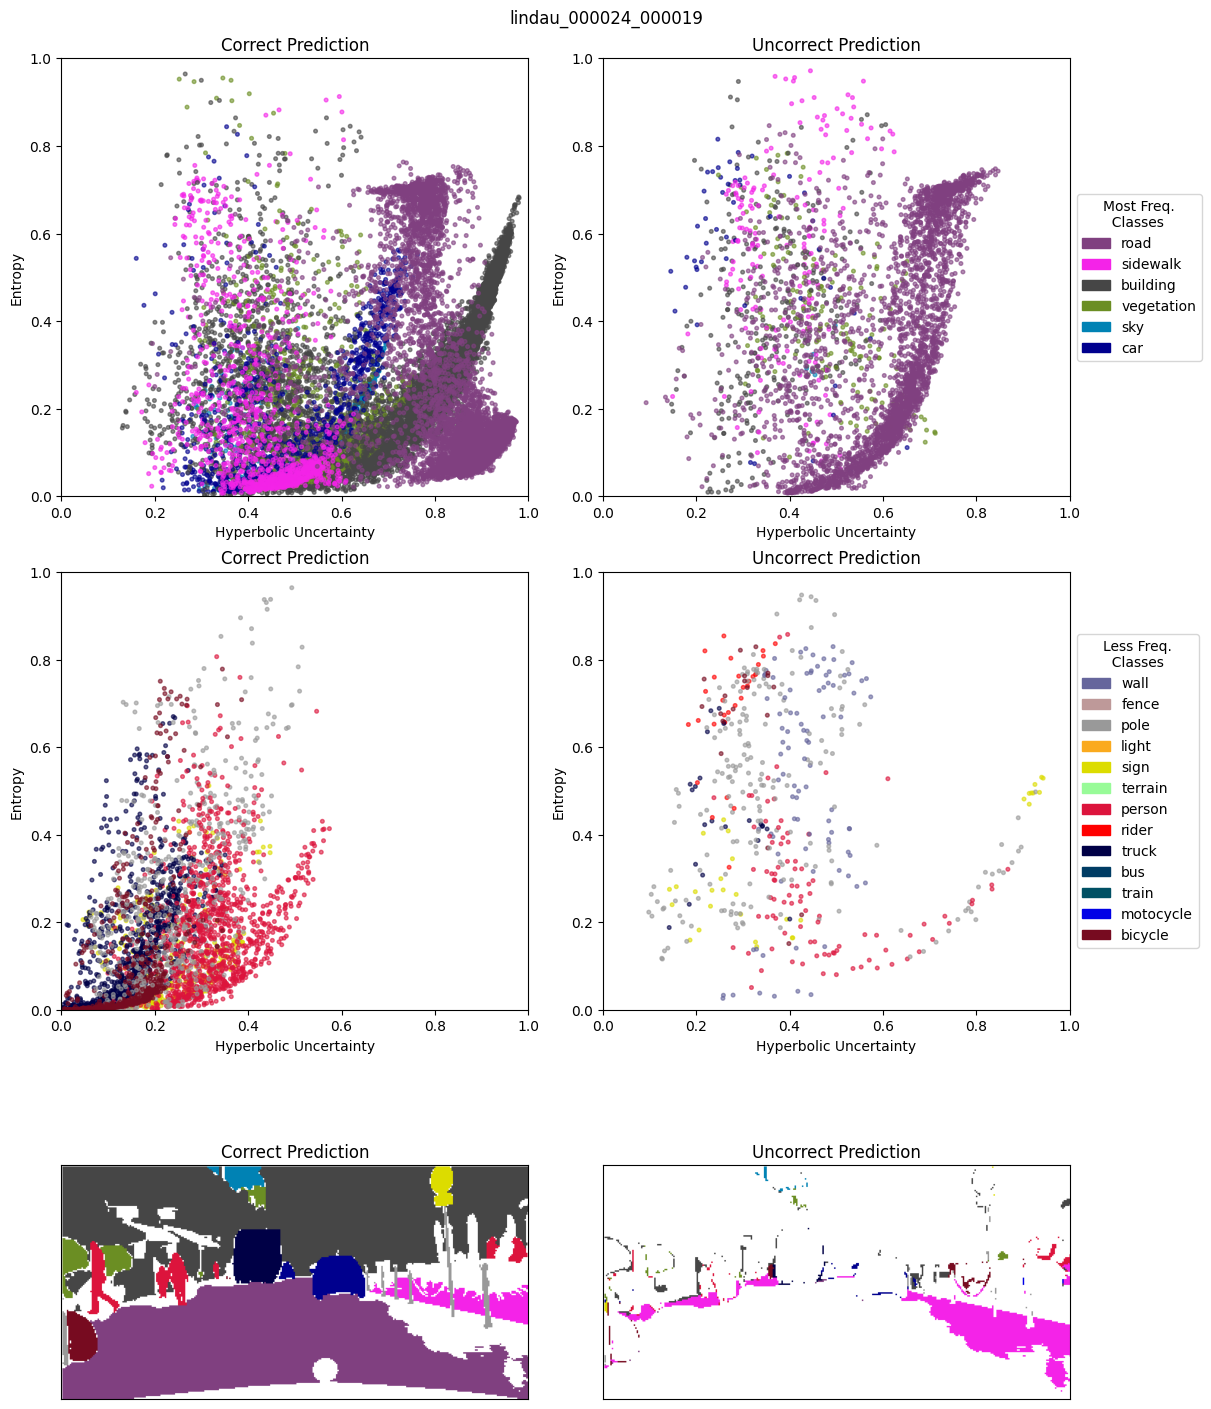

In [166]:
most_frequent_class = [0, 1, 2, 8, 10, 13]


# idx = 2
output_sel = output_tensor[idx].unsqueeze(0)
embed_sel = embed_tensor[idx].unsqueeze(0)


_, impurity, entropy = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='entropy', pur_type='ripu')
_, _, hyp_uncert = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='hyperbolic', pur_type='ripu')
hyp_cert = 1 - hyp_uncert
ent_cert = 1 - entropy



mask_correct = pred_tensor[idx] == label_tensor[idx]
total_mask = pred_tensor[idx] != label_tensor[idx]
mask_correct = mask_correct.reshape(-1)
mask_uncorrect = mask_uncorrect.reshape(-1)

label_flatten = label_tensor[idx].reshape(-1)

mask_known = label_flatten != 255.

mask_most_frequent = sum(label_flatten==i for i in most_frequent_class).bool()
mask_less_frequent = ~mask_most_frequent




fig, axes = plt.subplots(3, 2, figsize=(12, 15), constrained_layout = True) # constrained_layout = True


total_mask = mask_known & mask_correct & mask_most_frequent
label_correct = label_flatten[total_mask]
color_list = [extract_color(c) for c in label_correct.tolist()]

hyp_uncert_correct = hyp_uncert.reshape(-1)[total_mask]
entropy_correct = entropy.reshape(-1)[total_mask]
scatter1 = axes[0,0].scatter(hyp_uncert_correct, entropy_correct, c=color_list, alpha=.6, s=7)

axes[0,0].set_xlim(0, 1)
axes[0,0].set_ylim(0, 1)
axes[0,0].set_xlabel('Hyperbolic Uncertainty')
axes[0,0].set_ylabel('Entropy')
axes[0,0].set_title('Correct Prediction')


total_mask = mask_known & mask_uncorrect & mask_most_frequent
label_uncorrect = label_flatten[total_mask]
color_list = [extract_color(c) for c in label_uncorrect.tolist()]

hyp_uncert_uncorrect = hyp_uncert.reshape(-1)[total_mask]
entropy_uncorrect = entropy.reshape(-1)[total_mask]
scatter1 = axes[0,1].scatter(hyp_uncert_uncorrect, entropy_uncorrect, c=color_list, alpha=.6, s=7)

axes[0,1].set_xlim(0, 1)
axes[0,1].set_ylim(0, 1)
axes[0,1].set_xlabel('Hyperbolic Uncertainty')
axes[0,1].set_ylabel('Entropy')
axes[0,1].set_title('Uncorrect Prediction')

patchList = extract_legend(frequent='most')
axes[0,1].legend(handles=patchList, loc='center left', bbox_to_anchor=(1, 0.5), title="Most Freq.\n  Classes")


total_mask = mask_known & mask_correct & mask_less_frequent
label_correct = label_flatten[total_mask]
color_list = [extract_color(c) for c in label_correct.tolist()]

hyp_uncert_correct = hyp_uncert.reshape(-1)[total_mask]
entropy_correct = entropy.reshape(-1)[total_mask]
scatter3 = axes[1,0].scatter(hyp_uncert_correct, entropy_correct, c=color_list, alpha=.6, s=7)

axes[1,0].set_xlim(0, 1)
axes[1,0].set_ylim(0, 1)
axes[1,0].set_xlabel('Hyperbolic Uncertainty')
axes[1,0].set_ylabel('Entropy')
axes[1,0].set_title('Correct Prediction')


total_mask = mask_known & mask_uncorrect & mask_less_frequent
label_uncorrect = label_flatten[total_mask]
color_list = [extract_color(c) for c in label_uncorrect.tolist()]

hyp_uncert_uncorrect = hyp_uncert.reshape(-1)[total_mask]
entropy_uncorrect = entropy.reshape(-1)[total_mask]
scatter4 = axes[1,1].scatter(hyp_uncert_uncorrect, entropy_uncorrect, c=color_list, alpha=.6, s=7)

axes[1,1].set_xlim(0, 1)
axes[1,1].set_ylim(0, 1)
axes[1,1].set_xlabel('Hyperbolic Uncertainty')
axes[1,1].set_ylabel('Entropy')
axes[1,1].set_title('Uncorrect Prediction')

patchList = extract_legend(frequent='less')
axes[1,1].legend(handles=patchList, loc='center left', bbox_to_anchor=(1, 0.5), title="Less Freq.\n  Classes")




mask_known = label_tensor[idx] != 255
mask_correct = label_tensor[idx] == pred_tensor[idx]
total_mask = mask_known & mask_correct
total_mask = total_mask.cpu().numpy() * 1.

# pred_np_image = np.asarray(get_color_pallete(pred_tensor[idx].cpu().numpy()))

axes[2,0].set_title('Correct Prediction')
# axes[2,0].imshow(label_tensor[idx])
label_correct = pred_tensor[idx].cpu().numpy()*total_mask + 255*(1-total_mask)
im_score = axes[2,0].imshow(get_color_pallete(label_correct), alpha=1.)
axes[2,0].xaxis.set_visible(False)
axes[2,0].yaxis.set_visible(False)

mask_uncorrect = label_tensor[idx] != pred_tensor[idx]
total_mask = mask_known & mask_uncorrect
total_mask = total_mask.cpu().numpy() * 1.

axes[2,1].set_title('Uncorrect Prediction')
# axes[2,1].imshow(label_tensor[idx])
label_uncorrect = pred_tensor[idx].cpu().numpy()*total_mask + 255*(1-total_mask)
im_score = axes[2,1].imshow(get_color_pallete(label_uncorrect), alpha=1.)
axes[2,1].xaxis.set_visible(False)
axes[2,1].yaxis.set_visible(False)




fig.suptitle(name)
plt.savefig('./visualizzazioni/'+name+'_ent_vs_hyp_most_less_freq.png')

# Score Plots

In [167]:
# idx = 0
output_sel = output_tensor[idx].unsqueeze(0)
embed_sel = embed_tensor[idx].unsqueeze(0)

_, impurity, entropy = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='entropy', pur_type='ripu')
_, _, hyp_uncert = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='hyperbolic', pur_type='ripu')
hyp_cert = 1 - hyp_uncert
ent_cert = 1 - entropy

score = entropy * impurity

img_list = os.listdir(embed_path)
img = Image.open(os.path.join('datasets/cityscapes/leftImg8bit/val/', img_list[idx].split('_')[0], img_list[idx][:-3] + '_leftImg8bit.png'))
img = img.resize((entropy.shape[-1],entropy.shape[-2]), Image.NEAREST)


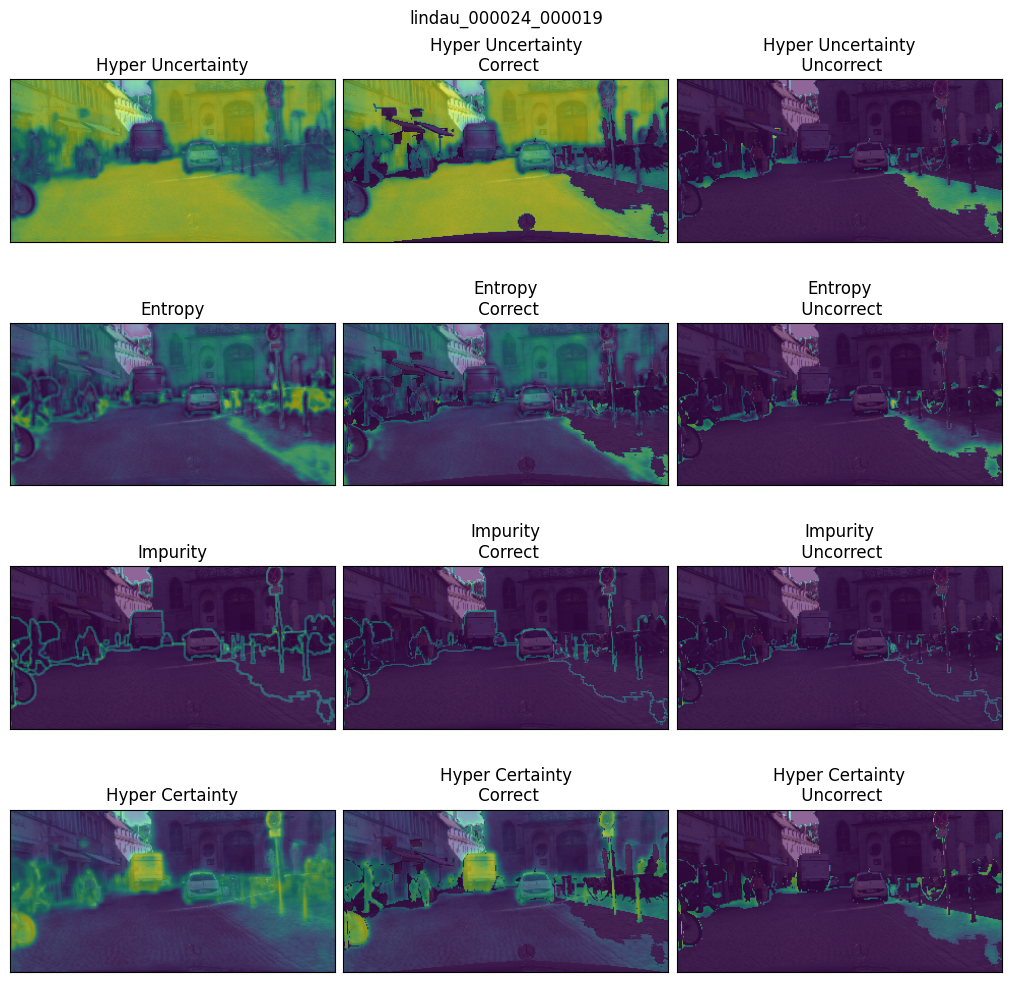

In [168]:
cmap1 = 'gray'
cmap2 = 'viridis'
alpha = 0.6

score_np = score.cpu().numpy()
entropy_np = entropy.cpu().numpy()
hypunc_np = hyp_uncert.cpu().numpy()
hypcert_np = hyp_cert.cpu().numpy()
impurity_np = impurity.cpu().numpy()

fig, axes = plt.subplots(4, 3, figsize=(10, 10), constrained_layout = True) # constrained_layout = True


axes[0,0].set_title('Hyper Uncertainty')
axes[0,0].imshow(img, cmap=cmap1)
im_score = axes[0,0].imshow(hypunc_np,  cmap=cmap2, alpha=alpha)
axes[0,0].xaxis.set_visible(False)
axes[0,0].yaxis.set_visible(False)

axes[1,0].set_title('Entropy')
axes[1,0].imshow(img, cmap=cmap1)
im_score = axes[1,0].imshow(entropy_np,  cmap=cmap2, alpha=alpha)
axes[1,0].xaxis.set_visible(False)
axes[1,0].yaxis.set_visible(False)

axes[2,0].set_title('Impurity')
axes[2,0].imshow(img, cmap=cmap1)
im_score = axes[2,0].imshow(impurity_np,  cmap=cmap2, alpha=alpha)
axes[2,0].xaxis.set_visible(False)
axes[2,0].yaxis.set_visible(False)

axes[3,0].set_title('Hyper Certainty')
axes[3,0].imshow(img, cmap=cmap1)
im_score = axes[3,0].imshow(hypcert_np,  cmap=cmap2, alpha=alpha)
axes[3,0].xaxis.set_visible(False)
axes[3,0].yaxis.set_visible(False)



# Plots for correct predictions only
mask_known = label_tensor[idx] != 255
mask_correct = label_tensor[idx] == pred_tensor[idx]
total_mask = mask_known & mask_correct
total_mask = total_mask.cpu().numpy() * 1.

axes[0,1].set_title('Hyper Uncertainty\n Correct')
axes[0,1].imshow(img, cmap=cmap1)
im_score = axes[0,1].imshow(hypunc_np*total_mask,  cmap=cmap2, alpha=alpha)
axes[0,1].xaxis.set_visible(False)
axes[0,1].yaxis.set_visible(False)

axes[1,1].set_title('Entropy\n Correct')
axes[1,1].imshow(img, cmap=cmap1)
im_score = axes[1,1].imshow(entropy_np*total_mask,  cmap=cmap2, alpha=alpha)
axes[1,1].xaxis.set_visible(False)
axes[1,1].yaxis.set_visible(False)

axes[2,1].set_title('Impurity\n Correct')
axes[2,1].imshow(img, cmap=cmap1)
im_score = axes[2,1].imshow(impurity_np*total_mask,  cmap=cmap2, alpha=alpha)
axes[2,1].xaxis.set_visible(False)
axes[2,1].yaxis.set_visible(False)

axes[3,1].set_title('Hyper Certainty\n Correct')
axes[3,1].imshow(img, cmap=cmap1)
im_score = axes[3,1].imshow(hypcert_np*total_mask,  cmap=cmap2, alpha=alpha)
axes[3,1].xaxis.set_visible(False)
axes[3,1].yaxis.set_visible(False)


# Plots for uncorrect predictions only
mask_known = label_tensor[idx] != 255
mask_uncorrect = label_tensor[idx] != pred_tensor[idx]
total_mask = mask_known & mask_uncorrect
total_mask = total_mask.cpu().numpy() * 1.

axes[0,2].set_title('Hyper Uncertainty\n Uncorrect')
axes[0,2].imshow(img, cmap=cmap1)
im_score = axes[0,2].imshow(hypunc_np*total_mask,  cmap=cmap2, alpha=alpha)
axes[0,2].xaxis.set_visible(False)
axes[0,2].yaxis.set_visible(False)

axes[1,2].set_title('Entropy\n Uncorrect')
axes[1,2].imshow(img, cmap=cmap1)
im_score = axes[1,2].imshow(entropy_np*total_mask,  cmap=cmap2, alpha=alpha)
axes[1,2].xaxis.set_visible(False)
axes[1,2].yaxis.set_visible(False)

axes[2,2].set_title('Impurity\n Uncorrect')
axes[2,2].imshow(img, cmap=cmap1)
im_score = axes[2,2].imshow(impurity_np*total_mask,  cmap=cmap2, alpha=alpha)
axes[2,2].xaxis.set_visible(False)
axes[2,2].yaxis.set_visible(False)

axes[3,2].set_title('Hyper Certainty\n Uncorrect')
axes[3,2].imshow(img, cmap=cmap1)
im_score = axes[3,2].imshow(hypcert_np*total_mask,  cmap=cmap2, alpha=alpha)
axes[3,2].xaxis.set_visible(False)
axes[3,2].yaxis.set_visible(False)



fig.suptitle(name)
plt.savefig('./visualizzazioni/'+name+'_all_scores_corr_uncorr.png')



# Histogram error vs certainty gap

## single sample

In [43]:
idx = 1

In [44]:
output_sel = output_tensor[idx].unsqueeze(0)
embed_sel = embed_tensor[idx].unsqueeze(0)

_, impurity, entropy = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='entropy', pur_type='ripu')
_, _, hyp_uncert = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='hyperbolic', pur_type='ripu')
hyp_cert = 1 - hyp_uncert
ent_cert = 1 - entropy

In [45]:
# flatten all the tensors
impurity_flatten = impurity.reshape(-1)
entropy_flatten = entropy.reshape(-1)
hyp_uncert_flatten = hyp_uncert.reshape(-1)
hyp_cert_flatten = hyp_cert.reshape(-1)

label_tensor_flatten = label_tensor[idx].reshape(-1)
pred_tensor_flatten = pred_tensor[idx].reshape(-1)

mask_known = label_tensor_flatten != 255
mask_correct = label_tensor_flatten == pred_tensor_flatten
mask_uncorrect = label_tensor_flatten != pred_tensor_flatten

In [46]:
impurity_correct = impurity_flatten[mask_known & mask_correct]
entropy_correct = entropy_flatten[mask_known & mask_correct]
hyp_uncert_correct = hyp_uncert_flatten[mask_known & mask_correct]
hyp_cert_correct = hyp_cert_flatten[mask_known & mask_correct]

impurity_uncorrect = impurity_flatten[mask_known & mask_uncorrect]
entropy_uncorrect = entropy_flatten[mask_known & mask_uncorrect]
hyp_uncert_uncorrect = hyp_uncert_flatten[mask_known & mask_uncorrect]
hyp_cert_uncorrect = hyp_cert_flatten[mask_known & mask_uncorrect]

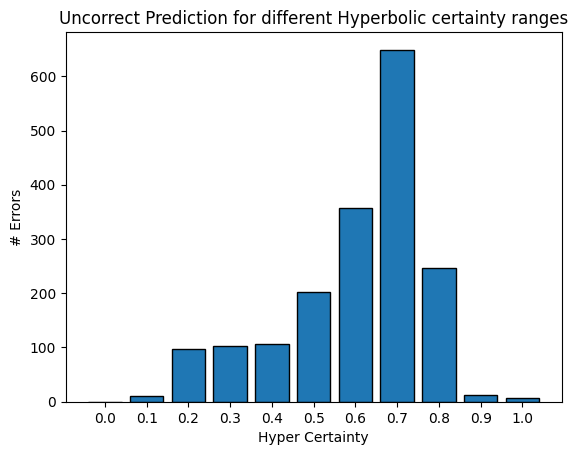

In [47]:
plt.hist(hyp_cert_uncorrect, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
plt.xticks(np.arange(0,1.1,0.1))
plt.ylabel("# Errors")
plt.xlabel("Hyper Certainty")
plt.title("Uncorrect Prediction for different Hyperbolic certainty ranges")
plt.show()

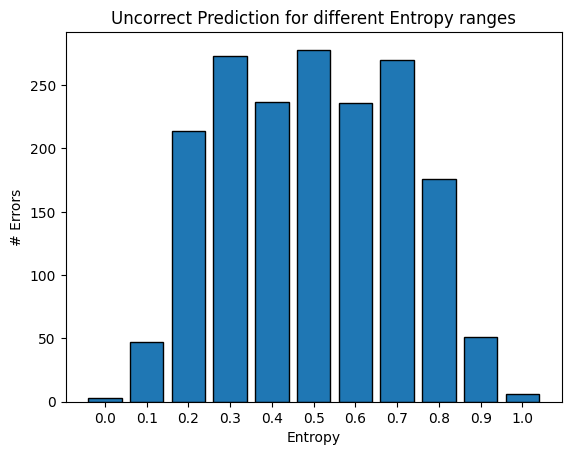

In [48]:
plt.hist(entropy_uncorrect, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8) # 
plt.xticks(np.arange(0,1.1,0.1))
plt.ylabel("# Errors")
plt.xlabel("Entropy")
plt.title("Uncorrect Prediction for different Entropy ranges")
plt.show()

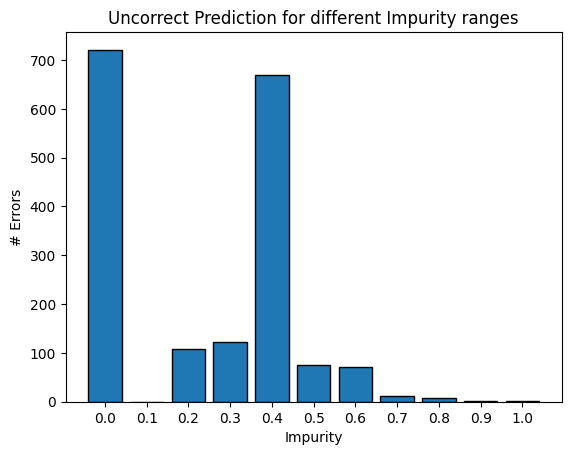

In [49]:
plt.hist(impurity_uncorrect, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8) # 
plt.xticks(np.arange(0,1.1,0.1))
plt.ylabel("# Errors")
plt.xlabel("Impurity")
plt.title("Uncorrect Prediction for different Impurity ranges")
plt.show()

## All data

In [52]:
output_tensor.shape, embed_tensor.shape

(torch.Size([500, 19, 160, 320]), torch.Size([500, 64, 160, 320]))

In [55]:
impurity_all = torch.empty(0, 160, 320)
entropy_all = torch.empty(0, 160, 320)
hypunc_all = torch.empty(0, 160, 320)
hyp_cert_all = torch.empty(0, 160, 320)

for idx in tqdm(range(500)):
    output_sel = output_tensor[idx].unsqueeze(0)
    embed_sel = embed_tensor[idx].unsqueeze(0)

    _, impurity, entropy = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='entropy', pur_type='ripu')
    _, _, hyp_uncert = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='hyperbolic', pur_type='ripu')
    hyp_cert = 1 - hyp_uncert
    # ent_cert = 1 - entropy
    impurity_all = torch.cat((impurity_all, impurity.unsqueeze(0)), dim=0)
    entropy_all = torch.cat((entropy_all, entropy.unsqueeze(0)), dim=0)
    hypunc_all = torch.cat((hypunc_all, hyp_uncert.unsqueeze(0)), dim=0)
    hyp_cert_all = torch.cat((hyp_cert_all, hyp_cert.unsqueeze(0)), dim=0)

100%|██████████| 500/500 [00:58<00:00,  8.59it/s]


In [56]:
# flatten all the tensors
impurity_flatten = impurity_all.reshape(-1)
entropy_flatten = entropy_all.reshape(-1)
hyp_uncert_flatten = hypunc_all.reshape(-1)
hyp_cert_flatten = hyp_cert_all.reshape(-1)

label_tensor_flatten = label_tensor.reshape(-1)
pred_tensor_flatten = pred_tensor.reshape(-1)

mask_known = label_tensor_flatten != 255
mask_correct = label_tensor_flatten == pred_tensor_flatten
mask_uncorrect = label_tensor_flatten != pred_tensor_flatten

In [59]:
impurity_correct = impurity_flatten[mask_known & mask_correct]
entropy_correct = entropy_flatten[mask_known & mask_correct]
hyp_uncert_correct = hyp_uncert_flatten[mask_known & mask_correct]
hyp_cert_correct = hyp_cert_flatten[mask_known & mask_correct]

impurity_uncorrect = impurity_flatten[mask_known & mask_uncorrect]
entropy_uncorrect = entropy_flatten[mask_known & mask_uncorrect]
hyp_uncert_uncorrect = hyp_uncert_flatten[mask_known & mask_uncorrect]
hyp_cert_uncorrect = hyp_cert_flatten[mask_known & mask_uncorrect]

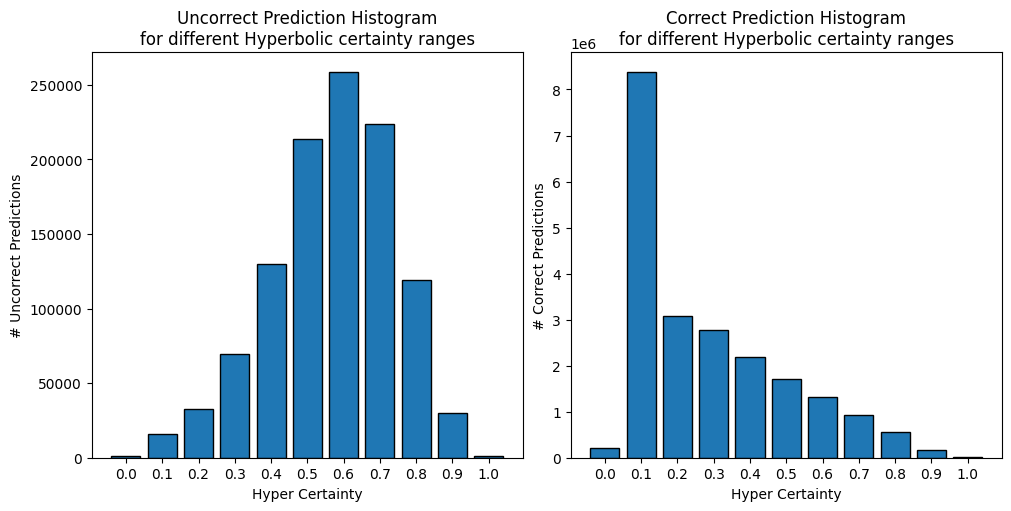

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), constrained_layout = True) # constrained_layout = True

ax1.hist(hyp_cert_uncorrect, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
ax1.set_xticks(np.arange(0,1.1,0.1))
ax1.set_ylabel("# Uncorrect Predictions")
ax1.set_xlabel("Hyper Certainty")
ax1.set_title("Uncorrect Prediction Histogram\nfor different Hyperbolic certainty ranges")

ax2.hist(hyp_cert_correct, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
ax2.set_xticks(np.arange(0,1.1,0.1))
ax2.set_ylabel("# Correct Predictions")
ax2.set_xlabel("Hyper Certainty")
ax2.set_title("Correct Prediction Histogram\nfor different Hyperbolic certainty ranges")

plt.savefig('./visualizzazioni/error_freq_hist_for_certainty_ranges.png')
plt.show()

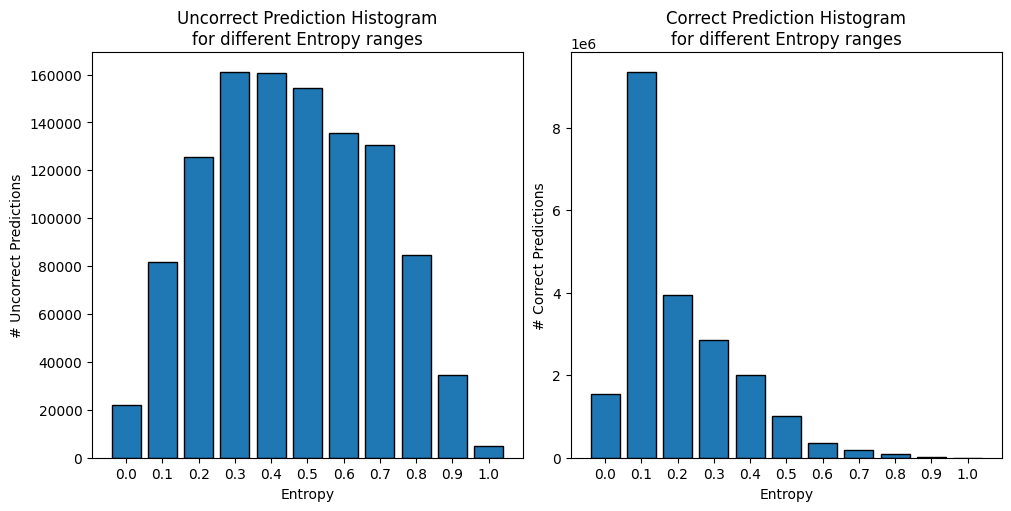

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), constrained_layout = True) # constrained_layout = True

ax1.hist(entropy_uncorrect, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
ax1.set_xticks(np.arange(0,1.1,0.1))
ax1.set_ylabel("# Uncorrect Predictions")
ax1.set_xlabel("Entropy")
ax1.set_title("Uncorrect Prediction Histogram\nfor different Entropy ranges")

ax2.hist(entropy_correct, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
ax2.set_xticks(np.arange(0,1.1,0.1))
ax2.set_ylabel("# Correct Predictions")
ax2.set_xlabel("Entropy")
ax2.set_title("Correct Prediction Histogram\nfor different Entropy ranges")

plt.savefig('./visualizzazioni/error_freq_hist_for_entropy_ranges.png')
plt.show()

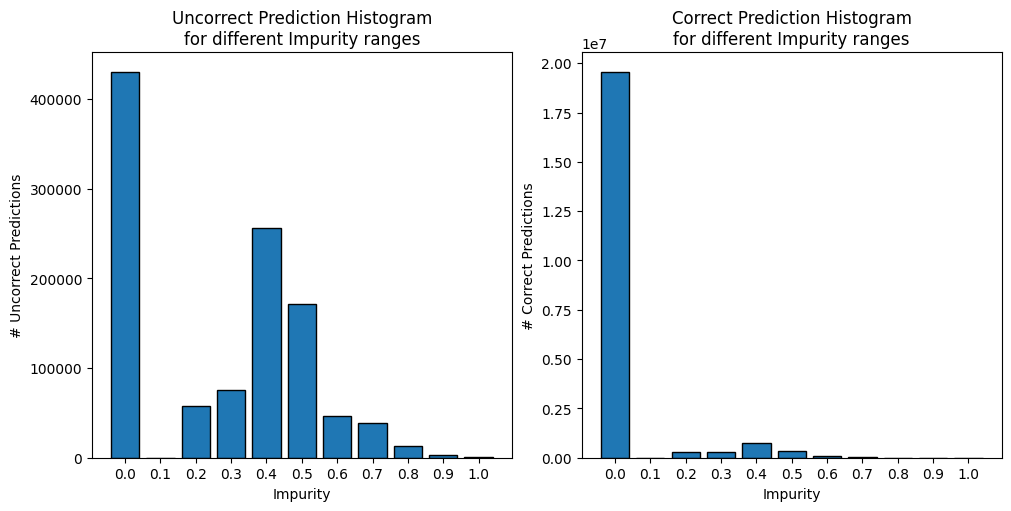

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), constrained_layout = True) # constrained_layout = True

ax1.hist(impurity_uncorrect, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
ax1.set_xticks(np.arange(0,1.1,0.1))
ax1.set_ylabel("# Uncorrect Predictions")
ax1.set_xlabel("Impurity")
ax1.set_title("Uncorrect Prediction Histogram\nfor different Impurity ranges")

ax2.hist(impurity_correct, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
ax2.set_xticks(np.arange(0,1.1,0.1))
ax2.set_ylabel("# Correct Predictions")
ax2.set_xlabel("Impurity")
ax2.set_title("Correct Prediction Histogram\nfor different Impurity ranges")

plt.savefig('./visualizzazioni/error_freq_hist_for_impurity_ranges.png')
plt.show()